In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/fer2013.csv")
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [ ]:
data.tail(10)

,emotion,pixels,Usage
35877,6,139 143 145 154 159 168 176 181 190 191 195 19...,PrivateTest
35878,3,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...,PrivateTest
35879,2,0 0 6 16 19 31 47 18 26 19 17 8 15 3 4 2 14 20...,PrivateTest
35880,2,164 172 175 171 172 173 178 181 188 192 197 20...,PrivateTest
35881,0,181 177 176 156 178 144 136 132 122 107 131 16...,PrivateTest
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [ ]:
data.shape

(35887, 3)

In [ ]:
data["emotion"].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [ ]:
data["Usage"].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [ ]:
data.isna().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f898f3d01c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f898f3d0700>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f898f567ee0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f898f3d0c40>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f898f3d0ee0>],
 'means': []}

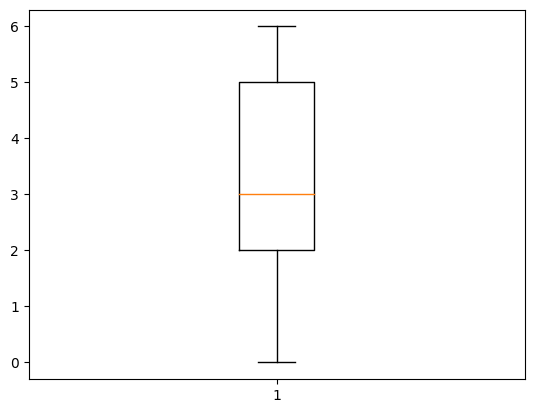

In [ ]:
plt.boxplot(data["emotion"])

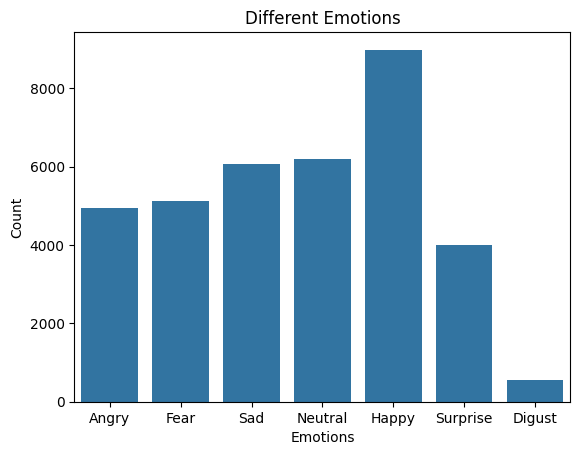

In [ ]:
data_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
data_count = data['emotion'].value_counts(sort=False).reset_index()
data_count.columns = ['emotion', 'counts']
data_count['emotion'] = data_count['emotion'].map(data_map)

sns.barplot(x='emotion', y='counts', data=data_count)
plt.title('Different Emotions')
plt.ylabel('Count')
plt.xlabel('Emotions')
plt.show()

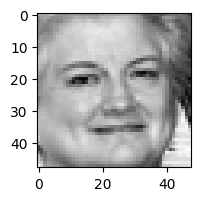

In [ ]:
one = data.loc[100]
pix = one["pixels"]
b = bytes(int(p) for p in pix.split())

i = Image.frombuffer('L', (48, 48), b)

plt.figure(figsize=(2, 2))
plt.gray()
plt.imshow(i)
plt.show()

In [ ]:
data1_train = data[data['Usage']=='Training'].copy()
data2_train = data[data['Usage']=='PrivateTest'].head(500).copy()

frames = [data1_train, data2_train]
train = pd.concat(frames)

validation = data[data['Usage']=='PublicTest'].copy()
test  = data[data['Usage']=='PrivateTest'].copy()

N_train, _ = train.shape
N_validation, _ = validation.shape
N_test, _ = test.shape


In [ ]:
def DataPrepare(e, N):
    e['pixels'] = e['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    X = np.array(e['pixels'].tolist(), dtype='float32').reshape(N, 48, 48, 1)/255.0
    Y = to_categorical(e['emotion'], 7)
    return X, Y

X_train, Y_train = DataPrepare(train, N_train) #training data
X_validation, Y_validation = DataPrepare(validation, N_validation) #validation data
X_test, Y_test = DataPrepare(test, N_test) #test data

In [ ]:
model = Sequential()

# Module 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Module 2
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Module 3
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Flatten
model.add(Flatten())

# Dense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 22, 22, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                   

In [ ]:
learningrate = 0.0001
epoch = 50

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow.keras.backend as K

# Clear previous sessions
K.clear_session()

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=learningrate),
              metrics=['accuracy'])

path_model = 'content/drive/MyDrive/model_full.h5'  # save model at this location after each epoch

# Define callbacks
callbacks = [
    ModelCheckpoint(filepath=path_model),
    ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)  # Reduce learning rate on plateau
]

# Fit the model
history = model.fit(x=X_train,
                    y=Y_train,
                    batch_size=30,  # Reduced batch size
                    epochs=10,      # Reduced number of epochs
                    verbose=1,
                    validation_data=(X_validation, Y_validation),
                    shuffle=True,
                    callbacks=callbacks
                    )


Epoch 1/10
974/974 [==============================] - 17s 11ms/step - loss: 1.7556 - accuracy: 0.2873 - val_loss: 1.6039 - val_accuracy: 0.3845 - lr: 1.0000e-04
Epoch 2/10
  7/974 [..............................] - ETA: 9s - loss: 1.6688 - accuracy: 0.3476 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


974/974 [==============================] - 10s 10ms/step - loss: 1.5500 - accuracy: 0.4023 - val_loss: 1.4493 - val_accuracy: 0.4539 - lr: 1.0000e-04
Epoch 3/10
974/974 [==============================] - 10s 11ms/step - loss: 1.4387 - accuracy: 0.4501 - val_loss: 1.3677 - val_accuracy: 0.4840 - lr: 1.0000e-04
Epoch 4/10
974/974 [==============================] - 10s 10ms/step - loss: 1.3549 - accuracy: 0.4821 - val_loss: 1.3089 - val_accuracy: 0.4954 - lr: 1.0000e-04
Epoch 5/10
974/974 [==============================] - 11s 11ms/step - loss: 1.2919 - accuracy: 0.5104 - val_loss: 1.2614 - val_accuracy: 0.5141 - lr: 1.0000e-04
Epoch 6/10
974/974 [==============================] - 11s 11ms/step - loss: 1.2373 - accuracy: 0.5282 - val_loss: 1.2285 - val_accuracy: 0.5386 - lr: 1.0000e-04
Epoch 7/10
974/974 [==============================] - 10s 10ms/step - loss: 1.1906 - accuracy: 0.5517 - val_loss: 1.2065 - val_accuracy: 0.5408 - lr: 1.0000e-04
Epoch 8/10
974/974 [=========================

In [ ]:
e = history.epoch
acc = history.history['accuracy']
valacc = history.history['val_accuracy']
loss = history.history['loss']
valloss = history.history['val_loss']
model.save('content/drive/MyDrive/model_full.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
Data_model = load_model('content/drive/MyDrive/model_full.h5')

In [ ]:
test_true = np.argmax(Y_test, axis=1)
test_pred = np.argmax(Data_model.predict(X_test), axis=1)
print("CNN Model Accuracy on testing set: {:.4f}".format(accuracy_score(test_true, test_pred)))

print('\nClassification Report:')
print(classification_report(test_true, test_pred))

print('Confusion Matrix:')
print(confusion_matrix(test_true, test_pred))

113/113 [==============================] - 0s 3ms/step
CNN Model Accuracy on testing set: 0.5801

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.52      0.53       491
           1       0.48      0.24      0.32        55
           2       0.40      0.36      0.38       528
           3       0.77      0.82      0.80       879
           4       0.42      0.41      0.41       594
           5       0.74      0.67      0.70       416
           6       0.53      0.61      0.57       626

    accuracy                           0.58      3589
   macro avg       0.55      0.52      0.53      3589
weighted avg       0.58      0.58      0.58      3589

Confusion Matrix:
[[257   3  47  30  74   6  74]
 [ 21  13   8   2   6   3   2]
 [ 71   2 189  32 107  53  74]
 [ 34   0  38 721  37  14  35]
 [ 54   5  83  67 241  13 131]
 [ 15   1  65  29   8 279  19]
 [ 36   3  44  53  98  10 382]]


In [ ]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))

    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')

    plt.show()

label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

1/1 [==============================] - 0s 244ms/step


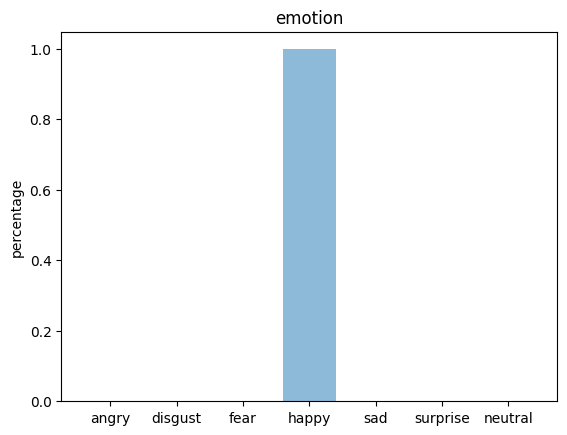

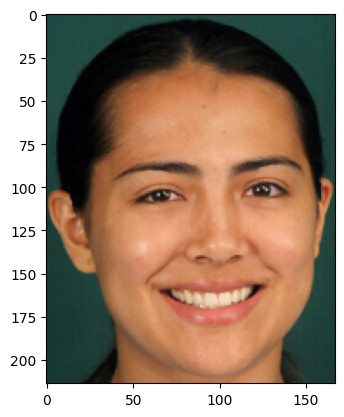

Expression Prediction:  Happy


In [ ]:
file = r"/content/drive/MyDrive/happy.png"
true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = Data_model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

plt.grid(False)
plt.imshow(true_image)
plt.show()
print('Expression Prediction: ', label_map[ind])


1/1 [==============================] - 0s 16ms/step


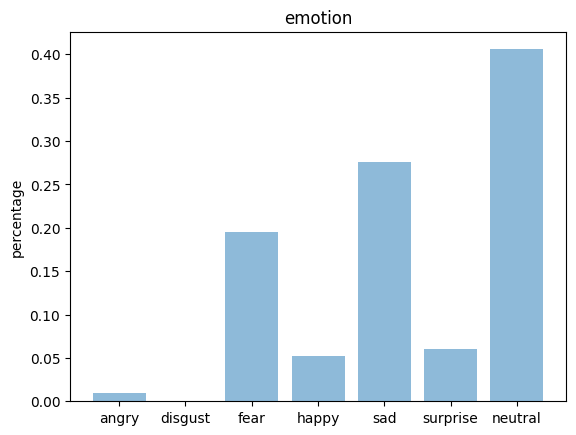

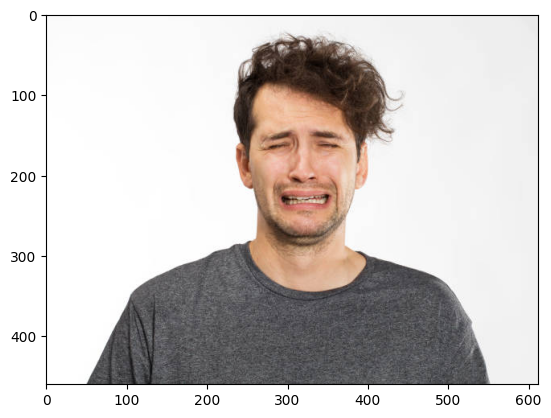

Expression Prediction:  Neutral


In [ ]:
file = r"/content/drive/MyDrive/sad.jpg"
true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = Data_model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

plt.grid(False)
plt.imshow(true_image)
plt.show()
print('Expression Prediction: ', label_map[ind])

1/1 [==============================] - 0s 19ms/step


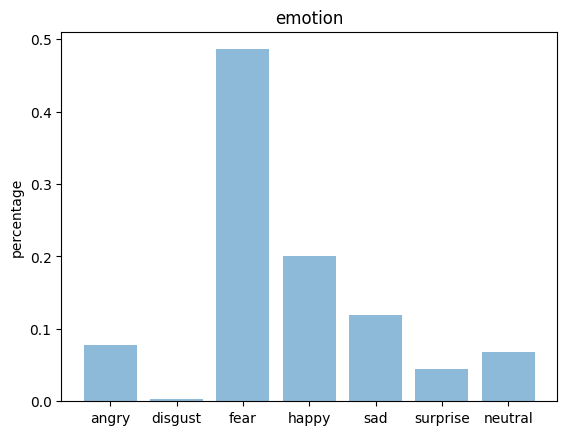

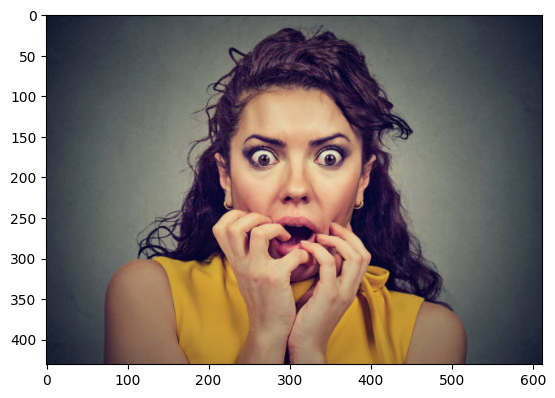

Expression Prediction:  Fear


In [ ]:
file = r"/content/drive/MyDrive/fear.jpg"
true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = Data_model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

plt.grid(False)
plt.imshow(true_image)
plt.show()
print('Expression Prediction: ', label_map[ind])

1/1 [==============================] - 0s 17ms/step


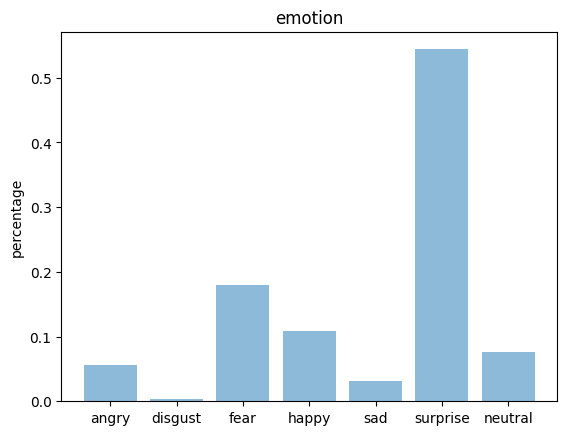

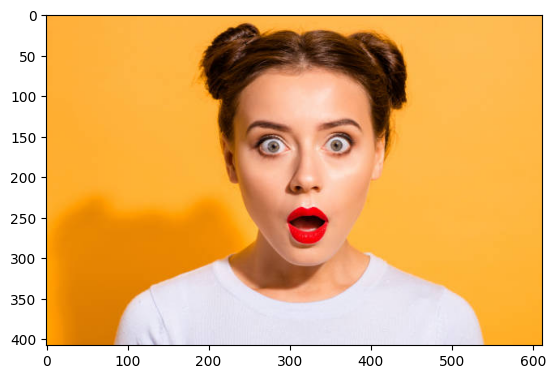

Expression Prediction:  Surprise


In [ ]:
file = r"/content/drive/MyDrive/suprised.jpg"
true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = Data_model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

plt.grid(False)
plt.imshow(true_image)
plt.show()
print('Expression Prediction: ', label_map[ind])


1/1 [==============================] - 0s 16ms/step


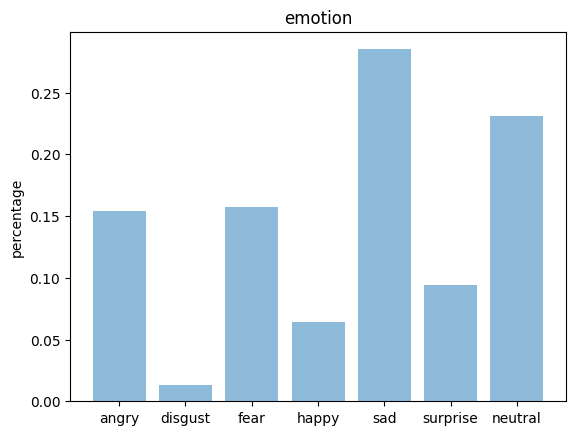

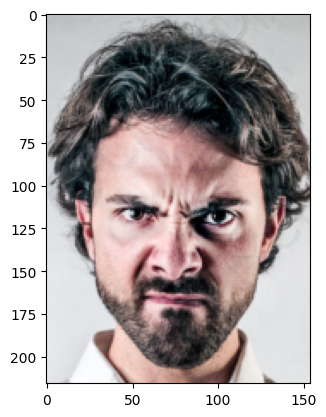

Expression Prediction:  Sad


In [ ]:
file = r"/content/drive/MyDrive/angry.png"
true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = Data_model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

plt.grid(False)
plt.imshow(true_image)
plt.show()
print('Expression Prediction: ', label_map[ind])


1/1 [==============================] - 0s 18ms/step


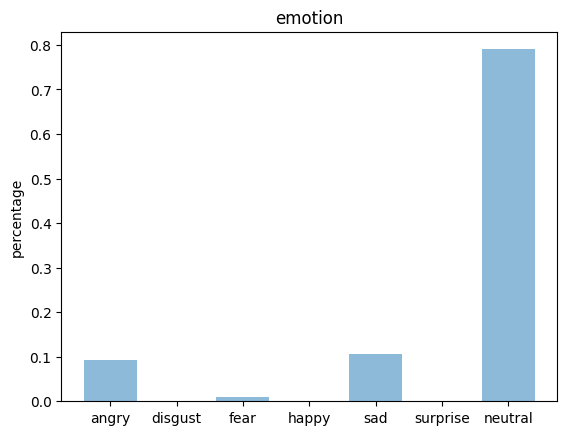

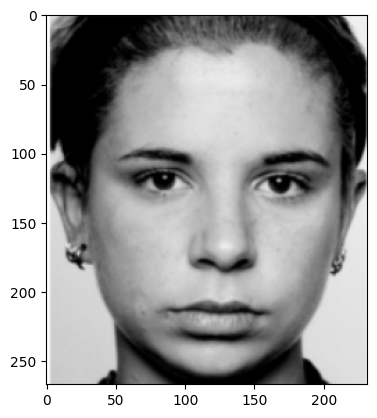

Expression Prediction:  Neutral


In [ ]:
file = r"/content/drive/MyDrive/neutral.png"
true_image = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = Data_model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i

plt.grid(False)
plt.imshow(true_image)
plt.show()
print('Expression Prediction: ', label_map[ind])